![alt text](https://cdn.discordapp.com/attachments/693138332166914077/698275109416206486/bootcamp.png)

# GENETIC VARIANT CLASSIFICATION

Clinic Variant is a public resource containing annotations about human genetic variants. These variants are (usually manually) classified by clinical laboratories on a categorical spectrum ranging from **benign, likely benign, uncertain significance, likely pathogenic, and pathogenic.** Variants that have conflicting classifications (from laboratory to laboratory) can cause confusion when clinicians or researchers try to interpret whether the variant has an impact on the disease of a given patient.

The objective is to predict whether a Clinic Variant  will have conflicting classifications. This is presented here as a binary classification problem, where each record in the dataset is a genetic variant.


![alt text](https://cdn.discordapp.com/attachments/693138332166914077/698141745719935036/concordant_variant.png)

![alt text](https://cdn.discordapp.com/attachments/693138332166914077/698141746902597662/conflicting_variant.png)

# **Distribution of Target**

![alt text](https://cdn.discordapp.com/attachments/693138332166914077/698141755178221629/target_histogram.png)

**The CLASS distribution is skewed a bit to the 0 class, meaning there are fewer variants with conflicting submissions.**

Since our target variable is binary (categorical), we will use both old and new models. These can be listed as follows:



*   Logistic Regression
*   XGBoost Classifier
*   KNeighbors Classifier
*   Decision Tree Classifier
*   LigthGBM Classifier
*   Gradient Boosting Classifier
*   Hist Gradient Boosting Classifier



# **Models Histogram**

![alt text](https://cdn.discordapp.com/attachments/693138332166914077/698263762855002164/Ekran_Resmi_2020-04-10_23.08.13.png)

In [0]:
#Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn import base
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
!pip install category_encoders
!pip install rfpimp
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,confusion_matrix
from google.colab import files
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

In [0]:
#Read The Dataset

url = "https://drive.google.com/uc?id=1TiEhIjpjB6KUxvqqgVeps9SkKTff1hvY"

data = pd.read_csv(url)

In [0]:
data.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,CLNDNINCL,CLNHGVS,CLNSIGINCL,CLNVC,CLNVI,MC,ORIGIN,SSR,CLASS,Allele,Consequence,IMPACT,SYMBOL,Feature_type,Feature,BIOTYPE,EXON,INTRON,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,DISTANCE,STRAND,BAM_EDIT,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,955563,G,C,0.0000,0.00000,0.0000,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",NaN,NC_000001.10:g.955563G>C,NaN,single_nucleotide_variant,NaN,SO:0001583|missense_variant,1.0,NaN,0,C,missense_variant,MODERATE,AGRN,Transcript,NM_001305275.1,protein_coding,1/39,NaN,61,11,4,R/P,cGg/cCg,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.421,11.390,1.133255,-2.0
1,1,955597,G,T,0.0000,0.42418,0.2826,MedGen:CN169374,NaN,not_specified,NaN,NC_000001.10:g.955597G>T,NaN,single_nucleotide_variant,NaN,SO:0001819|synonymous_variant,1.0,NaN,0,T,synonymous_variant,LOW,AGRN,Transcript,NM_001305275.1,protein_coding,1/39,NaN,95,45,15,P,ccG/ccT,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.421,8.150,0.599088,NaN
2,1,955619,G,C,0.0000,0.03475,0.0088,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",NaN,NC_000001.10:g.955619G>C,NaN,single_nucleotide_variant,NaN,SO:0001583|missense_variant,1.0,NaN,1,C,missense_variant,MODERATE,AGRN,Transcript,NM_001305275.1,protein_coding,1/39,NaN,117,67,23,V/L,Gtc/Ctc,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.421,3.288,0.069819,1.0
3,1,957640,C,T,0.0318,0.02016,0.0328,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",NaN,NC_000001.10:g.957640C>T,NaN,single_nucleotide_variant,NaN,SO:0001819|synonymous_variant,1.0,NaN,0,T,synonymous_variant,LOW,AGRN,Transcript,NM_001305275.1,protein_coding,2/39,NaN,311,261,87,D,gaC/gaT,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.421,12.560,1.356499,NaN
4,1,976059,C,T,0.0000,0.00022,0.0010,MedGen:CN169374,NaN,not_specified,NaN,NC_000001.10:g.976059C>T,NaN,single_nucleotide_variant,NaN,SO:0001819|synonymous_variant,1.0,NaN,1,T,synonymous_variant,LOW,AGRN,Transcript,NM_001305275.1,protein_coding,4/39,NaN,576,526,176,L,Ctg/Ttg,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.421,17.740,2.234711,NaN


In [0]:
data.shape

(65188, 46)

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        76 non-null     object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           76 non-null     object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          76 non-null     object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  58219 non-null  object 
 16  ORIG

In [0]:
#Inserting KEY

#In this data, we define a column with a unique value of 65188 as a key.

data.insert(0,"KEY",data.CLNHGVS)

In [0]:
data['KEY'].nunique()==len(data)

True

In [0]:
data.describe()

,POS,AF_ESP,AF_EXAC,AF_TGP,ORIGIN,SSR,CLASS,DISTANCE,STRAND,MOTIF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
count,6.518800e+04,65188.000000,65188.000000,65188.000000,59065.000000,104.000000,65188.000000,108.000000,65174.000000,2.0,2.000000,60975.000000,64096.000000,64096.000000,25593.000000
mean,7.757594e+07,0.014511,0.014492,0.015263,1.272869,2.298077,0.252102,825.731481,-0.006659,1.0,-0.080000,0.345058,15.685616,2.554131,-0.402258
std,5.974051e+07,0.057795,0.059542,0.059527,5.343258,4.237786,0.434223,1069.363315,0.999985,0.0,0.024042,0.361238,10.836350,2.961553,1.872684
min,9.610000e+02,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,1.0,-0.097000,0.000069,0.001000,-5.477391,-3.000000
25%,3.254179e+07,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,55.500000,-1.000000,1.0,-0.088500,0.024300,7.141000,0.462951,-2.000000
50%,5.797021e+07,0.000000,0.000040,0.000000,1.000000,1.000000,0.000000,469.000000,-1.000000,1.0,-0.080000,0.157000,14.090000,1.642948,-1.000000
75%,1.127454e+08,0.001200,0.001230,0.001600,1.000000,1.000000,1.000000,1415.000000,1.000000,1.0,-0.071500,0.710000,24.100000,4.381392,1.000000
max,2.476080e+08,0.499000,0.499890,0.499800,513.000000,16.000000,1.000000,4759.000000,1.000000,1.0,-0.063000,1.000000,99.000000,46.556261,3.000000


## **Histogram of Binary Target Categories**

In [0]:
%matplotlib inline
# Histogram of the target categories
def histogram(df,feature):
    ncount = len(df)
    ax = sns.countplot(x = feature, data=df ,palette="hls")
    sns.set(font_scale=1)
    ax.set_xlabel('Target Segments')
    plt.xticks(rotation=90)
    ax.set_ylabel('Number of Observations')
    fig = plt.gcf()
    fig.set_size_inches(12,5)
    # Make twin axis
    ax2=ax.twinx()
    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()
    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('Frequency [%]')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))
    # Fix the frequency range to 0-100
    ax2.set_ylim(0,100)
    ax.set_ylim(0,ncount)
    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)
    plt.title('Histogram of Binary Target Categories', fontsize=20, y=1.08)
    plt.show()
    plt.savefig('target_histogram.png')
    del ncount, x, y

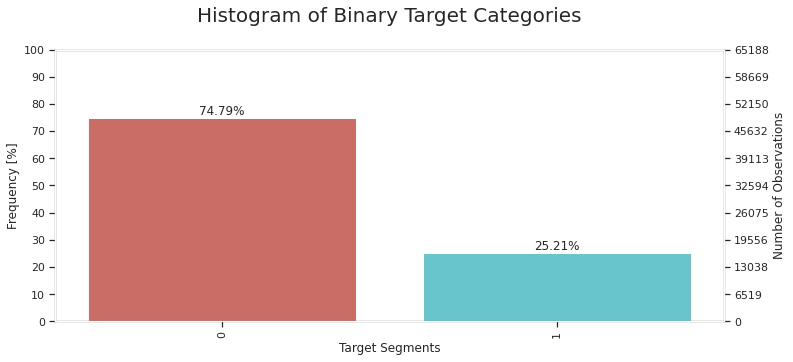

<Figure size 432x288 with 0 Axes>

In [0]:
histogram(data,"CLASS")

**The CLASS distribution is skewed a bit to the 0 class, meaning there are fewer variants with conflicting submissions.**



### **Information function about missing values**

In [0]:
def MissingUniqueStatistics(df):
  
  total_entry_list = []
  total_missing_value_list = []
  missing_value_ratio_list = []
  data_type_list = []
  unique_values_list = []
  number_of_unique_values_list = []
  variable_name_list = []
  
  for col in df.columns:

    variable_name_list.append(col)
    missing_value_ratio = round((df[col].isna().sum()/len(df[col])),4)
    total_entry_list.append(df[col].shape[0] - df[col].isna().sum())
    total_missing_value_list.append(df[col].isna().sum())
    missing_value_ratio_list.append(missing_value_ratio)
    data_type_list.append(df[col].dtype)
    unique_values_list.append(list(df[col].unique()))
    number_of_unique_values_list.append(len(df[col].unique()))

  data_info_df = pd.DataFrame({'Variable':variable_name_list,'#_Total_Entry':total_entry_list,\
                           '#_Missing_Value':total_missing_value_list,'%_Missing_Value':missing_value_ratio_list,\
                           'Data_Type':data_type_list,'Unique_Values':unique_values_list,\
                           '#_Uniques_Values':number_of_unique_values_list})
  
  return data_info_df.sort_values(by="#_Missing_Value",ascending=False)

In [0]:
data_info = MissingUniqueStatistics(data)
data_info = data_info.set_index("Variable")
data_info

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,Unique_Values,#_Uniques_Values
Variable,,,,,,
MOTIF_SCORE_CHANGE,2,65186,1.0000,float64,"[nan, -0.063, -0.09699999999999999]",3
HIGH_INF_POS,2,65186,1.0000,object,"[nan, N]",2
MOTIF_POS,2,65186,1.0000,float64,"[nan, 1.0]",2
MOTIF_NAME,2,65186,1.0000,object,"[nan, Egr1:MA0341.1, FOXA1:MA0546.1]",3
CLNSIGINCL,76,65112,0.9988,object,"[nan, 427816:Likely_pathogenic, 424754:Likely_...",69
CLNDISDBINCL,76,65112,0.9988,object,"[nan, MedGen:C0268342,OMIM:225400,Orphanet:ORP...",49
CLNDNINCL,76,65112,0.9988,object,"[nan, Ehlers-Danlos_syndrome,_hydroxylysine-de...",55
SSR,104,65084,0.9984,float64,"[nan, 1.0, 16.0]",3
DISTANCE,108,65080,0.9983,float64,"[nan, 1407.0, 1410.0, 1430.0, 1497.0, 499.0, 3...",97


### When we analyze the missing value statistics, we see that our 9 columns are larger than 99%. These columns do not contain information. That's why we drop these columns.

In [0]:
drop_list = list(data_info[data_info["%_Missing_Value"] >= 0.99].index)

data.drop(drop_list,axis = 1,inplace = True) # --> MAIN DF CHANGED

### When we continue to analyze the missing data statistics, we see that there are 3 different columns with numerical data, but the data type is an object.

In [0]:
data["Protein_position"].unique() , data["CDS_position"].unique()  , data["cDNA_position"].unique()

(array(['4', '15', '23', ..., '258-260', '2593-2594', '2212-2213'],
       dtype=object),
 array(['11', '45', '67', ..., '248-252', '1491-1492', '1492-1494'],
       dtype=object),
 array(['61', '95', '117', ..., '496-500', '1701-1702', '1702-1704'],
       dtype=object))

### We see that some data is separated by "-". And these numbers are very close to each other. Based on this information, we can only use the first number.

In [0]:
def value_correction(df,columns):
  
  for col in columns:

    value_correction = pd.DataFrame(df[col][df[col].notnull()].str.split("-").tolist(),columns=["X","Y"])
    value_correction["X"][value_correction["X"]=="?"] = value_correction["Y"]
    key = df[[col,"KEY"]][df[col].notnull()]["KEY"]

    counter = 0

    for i in key.index:

      df[col][i] = value_correction["X"][counter]
      counter += 1

    df[col] = df[col].astype(float)
  return df

In [0]:
data = value_correction(data,["CDS_position","cDNA_position","Protein_position"]) # --> MAIN DF CHANGED

# Showing the correlation map of the dataset

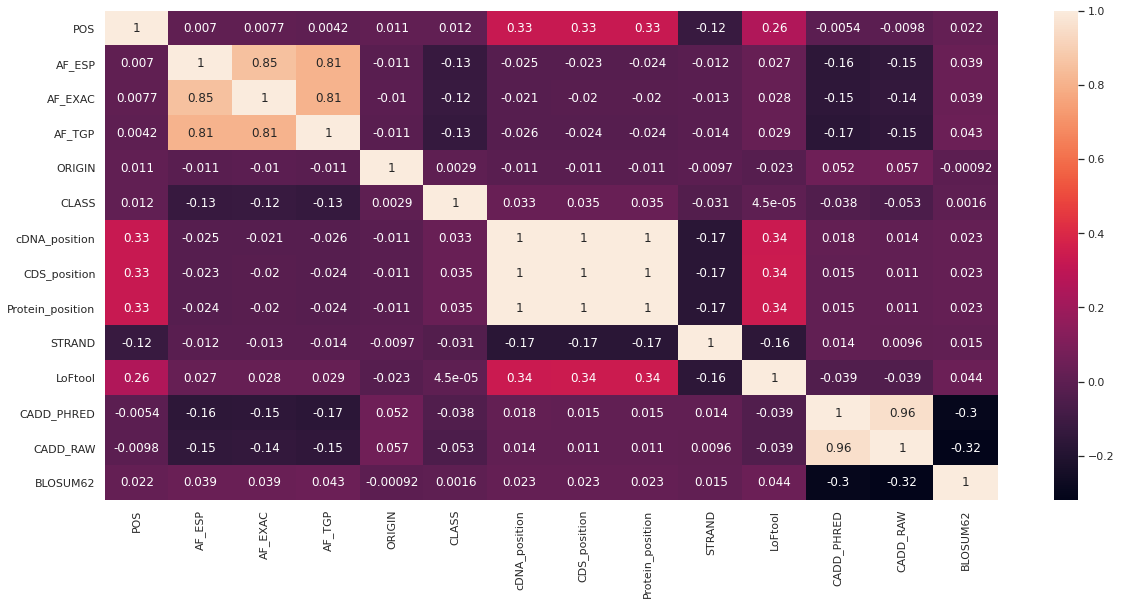

In [0]:
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(data.corr(), annot=True)
plt.show()

When we analyze this map, we see that the correlation of cDNA_position, CDS_position, Protein_position columns with each other is 1.And more than 85% of the CDS_position values ​​are filled with 3 times the Protein_position value.Also, the value of cDNA_position is 50 numbers larger than CDS_position.

Therefore, we dropped the cDNA_position and CDS_position columns.

In [0]:
data.drop(["CDS_position","cDNA_position"],axis = 1, inplace = True) # --> MAIN DF CHANGED

When we continue to analyze the table of missing values ​​statistics, we see that we have two columns with fractional numbers but the data type is an object.These are "EXON" and "INTRON" columns.

We make the data type of these columns "float".



In [0]:
data[["EXON","INTRON"]][data["INTRON"].notnull() & data["EXON"].notnull()].head(10)

,EXON,INTRON
562,5/28,4/27
1169,14/16,14/15
3360,10/11,10/10
5370,8/16,7/15
7545,16/20,15/19
9008,343/363,343/362
15618,29/30,28/29
16814,7/11,6/10
16940,10/13,10/12
19796,23/25,23/24


In [0]:
def convert_to_float(df,columns):
  
  for col in columns:
       
    convert_to_float = pd.DataFrame(df[col][df[col].notnull()].str.split("/").tolist(),columns=["Numerator","Denominator"])
    convert_to_float = convert_to_float.astype("float")
    convert_to_float["Result"] = convert_to_float["Numerator"] / convert_to_float["Denominator"]
    key =df[[col,"KEY"]][df[col].notnull()]["KEY"]

    counter = 0
    for i in key.index:

      df[col][i] = convert_to_float["Result"][counter]
      counter += 1
    df[col] = df[col].astype(float)

  return df

In [0]:
data = convert_to_float(data,["INTRON","EXON"]) # --> MAIN DF CHANGED

In [0]:
MissingUniqueStatistics(data)

,Variable,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,Unique_Values,#_Uniques_Values
24,INTRON,8803,56385,0.8650,float64,"[nan, 0.15789473684210525, 0.42105263157894735...",1269
31,PolyPhen,24796,40392,0.6196,object,"[nan, benign, probably_damaging, possibly_dama...",5
30,SIFT,24836,40352,0.6190,object,"[nan, tolerated, deleterious, deleterious_low_...",5
35,BLOSUM62,25593,39595,0.6074,float64,"[-2.0, nan, 1.0, -1.0, -3.0, 3.0, 2.0]",7
12,CLNVI,27659,37529,0.5757,object,"[nan, UniProtKB_(protein):Q96L58, OMIM_Allelic...",26290
29,BAM_EDIT,31969,33219,0.5096,object,"[nan, OK, FAILED]",3
27,Codons,55184,10004,0.1535,object,"[cGg/cCg, ccG/ccT, Gtc/Ctc, gaC/gaT, Ctg/Ttg, ...",2221
26,Amino_acids,55184,10004,0.1535,object,"[R/P, P, V/L, D, L, G, T/I, A, Q/R, A/S, nan, ...",1263
25,Protein_position,55233,9955,0.1527,float64,"[4.0, 15.0, 23.0, 87.0, 176.0, 243.0, 246.0, 2...",6369
23,EXON,56295,8893,0.1364,float64,"[0.02564102564102564, 0.05128205128205128, 0.1...",2102


# Showing missing values on the bar graphic

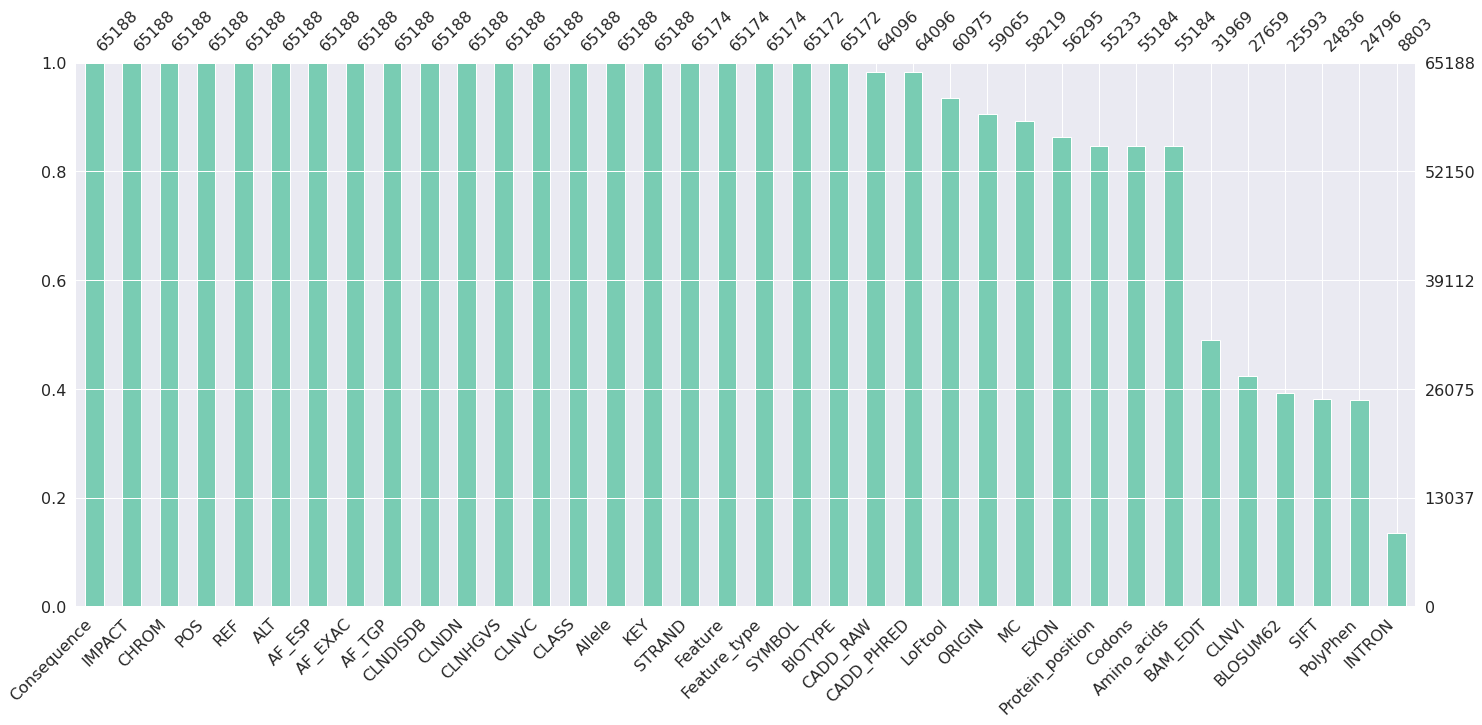

In [0]:
msno.bar(data,color='#79ccb3',sort='descending')
plt.show()

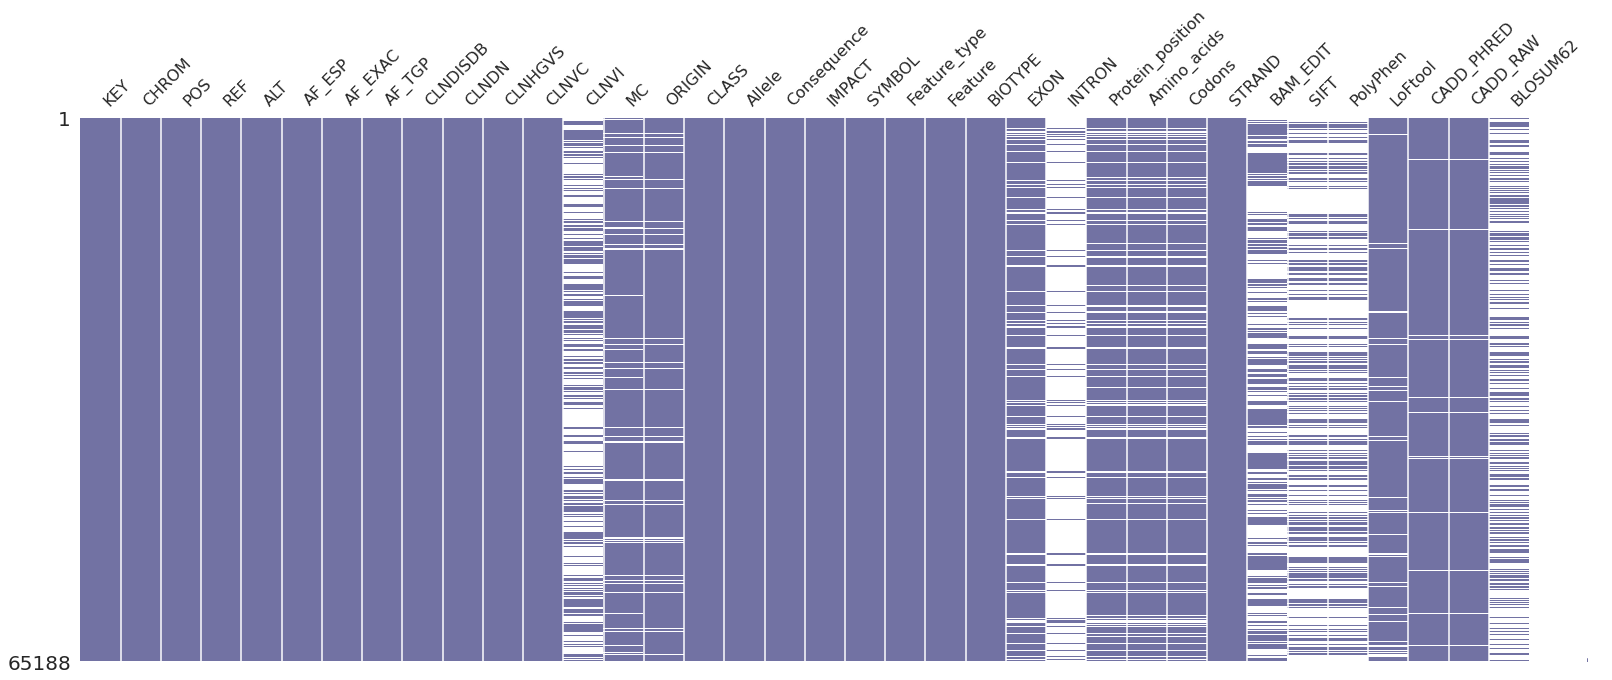

In [0]:
msno.matrix(data,color=(0.45,0.45,0.64),figsize=(27, 10), width_ratios=(10, 0))
plt.show()

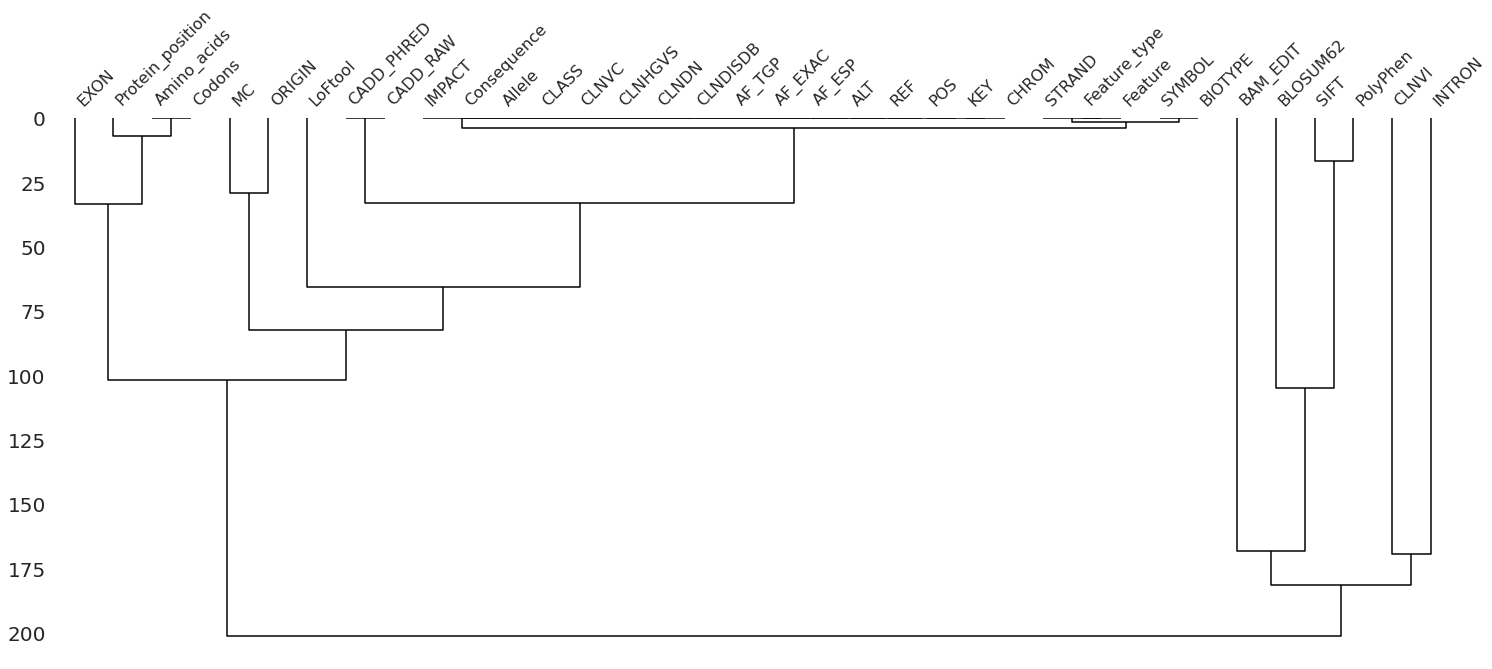

In [0]:
msno.dendrogram(data);

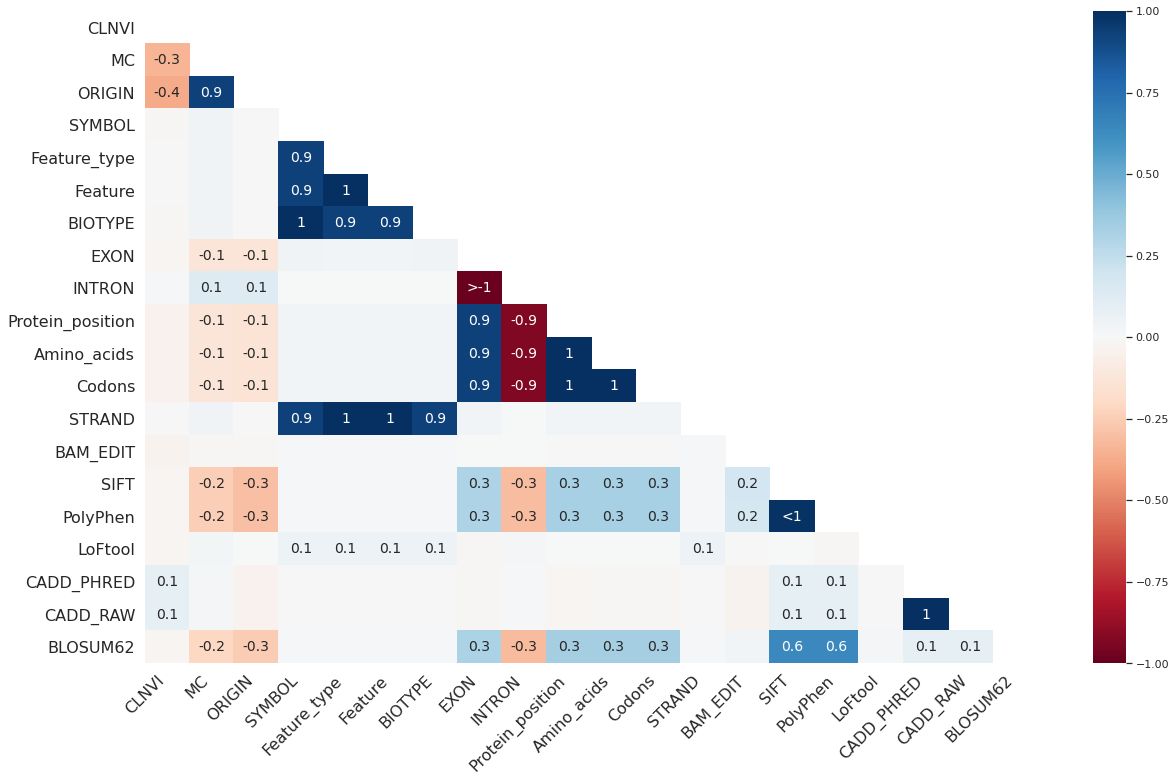

In [0]:
msno.heatmap(data)
plt.show()

We have a heapmap showing the relationship of missing values ​​with each other. On this map, we see that the "EXON" and "INTRON" columns are inversely related to each other. Therefore, we fill in the missing values ​​of the column "EXON" with the values ​​of the column "INTRON".

In [0]:
data["EXON"][data["EXON"].isnull()]

11      NaN
26      NaN
32      NaN
33      NaN
47      NaN
         ..
65183   NaN
65184   NaN
65185   NaN
65186   NaN
65187   NaN
Name: EXON, Length: 8893, dtype: float64

In [0]:
data["INTRON"][data["INTRON"].notnull()]

11       0.157895
26       0.421053
32       0.526316
33       0.526316
47       0.657895
           ...   
65130    0.666667
65131    0.777778
65136    0.200000
65139    0.916667
65142    0.833333
Name: INTRON, Length: 8803, dtype: float64

In [0]:
data["EXON"][data["EXON"].isnull()] = data["INTRON"][data["INTRON"].notnull()] # --> MAIN DF CHANGED

Then we drop the "INTRON" column.

In [0]:
data.drop(["INTRON"], axis = 1, inplace = True) # --> MAIN DF CHANGED

In [0]:
data_info = MissingUniqueStatistics(data)
data_info = data_info.set_index("Variable")
data_info

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,Unique_Values,#_Uniques_Values
Variable,,,,,,
PolyPhen,24796,40392,0.6196,object,"[nan, benign, probably_damaging, possibly_dama...",5
SIFT,24836,40352,0.6190,object,"[nan, tolerated, deleterious, deleterious_low_...",5
BLOSUM62,25593,39595,0.6074,float64,"[-2.0, nan, 1.0, -1.0, -3.0, 3.0, 2.0]",7
CLNVI,27659,37529,0.5757,object,"[nan, UniProtKB_(protein):Q96L58, OMIM_Allelic...",26290
BAM_EDIT,31969,33219,0.5096,object,"[nan, OK, FAILED]",3
Amino_acids,55184,10004,0.1535,object,"[R/P, P, V/L, D, L, G, T/I, A, Q/R, A/S, nan, ...",1263
Codons,55184,10004,0.1535,object,"[cGg/cCg, ccG/ccT, Gtc/Ctc, gaC/gaT, Ctg/Ttg, ...",2221
Protein_position,55233,9955,0.1527,float64,"[4.0, 15.0, 23.0, 87.0, 176.0, 243.0, 246.0, 2...",6369
MC,58219,6969,0.1069,object,"[SO:0001583|missense_variant, SO:0001819|synon...",90


In [0]:
#Creating new column for add of variable type
data_info["Variable_Type"] = ["Ordinal","Ordinal","Nominal","Nominal","Nominal","Nominal","Nominal","Continuous","Nominal",
                              "Continuous","Continuous","Continuous","Continuous","Continuous","Nominal","Nominal","Nominal",
                              "Nominal","Nominal","Nominal","Nominal","Ordinal","Nominal","Nominal","Nominal","Nominal","Nominal","Nominal",
                              "Continuous","Continuous","Continuous","Nominal","Nominal","Cardinal","Ordinal"]
data_info

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,Unique_Values,#_Uniques_Values,Variable_Type
Variable,,,,,,,
PolyPhen,24796,40392,0.6196,object,"[nan, benign, probably_damaging, possibly_dama...",5,Ordinal
SIFT,24836,40352,0.6190,object,"[nan, tolerated, deleterious, deleterious_low_...",5,Ordinal
BLOSUM62,25593,39595,0.6074,float64,"[-2.0, nan, 1.0, -1.0, -3.0, 3.0, 2.0]",7,Nominal
CLNVI,27659,37529,0.5757,object,"[nan, UniProtKB_(protein):Q96L58, OMIM_Allelic...",26290,Nominal
BAM_EDIT,31969,33219,0.5096,object,"[nan, OK, FAILED]",3,Nominal
Amino_acids,55184,10004,0.1535,object,"[R/P, P, V/L, D, L, G, T/I, A, Q/R, A/S, nan, ...",1263,Nominal
Codons,55184,10004,0.1535,object,"[cGg/cCg, ccG/ccT, Gtc/Ctc, gaC/gaT, Ctg/Ttg, ...",2221,Nominal
Protein_position,55233,9955,0.1527,float64,"[4.0, 15.0, 23.0, 87.0, 176.0, 243.0, 246.0, 2...",6369,Continuous
MC,58219,6969,0.1069,object,"[SO:0001583|missense_variant, SO:0001819|synon...",90,Nominal


## **Data Controlling**

In [0]:
# 1- Row Uniqueness (Drop Duplicates) 
len(data_info.index) == data_info.shape[0]

True

In [0]:
# 2- Column Uniqueness (Drop Singletons)
numerical_columns = list(data_info.loc[(data_info.loc[:,"Variable_Type"]=="Cardinal") |
                                       (data_info.loc[:,"Variable_Type"]=="Continuous")].index)
len(numerical_columns), numerical_columns

(10,
 ['Protein_position',
  'ORIGIN',
  'LoFtool',
  'CADD_PHRED',
  'CADD_RAW',
  'EXON',
  'AF_TGP',
  'AF_EXAC',
  'AF_ESP',
  'POS'])

In [0]:
categorical_columns = list(data_info.loc[(data_info.loc[:,"Variable_Type"]=="Nominal") |
                                       (data_info.loc[:,"Variable_Type"]=="Ordinal")].index)
len(categorical_columns), categorical_columns

(25,
 ['PolyPhen',
  'SIFT',
  'BLOSUM62',
  'CLNVI',
  'BAM_EDIT',
  'Amino_acids',
  'Codons',
  'MC',
  'SYMBOL',
  'BIOTYPE',
  'STRAND',
  'Feature',
  'Feature_type',
  'KEY',
  'IMPACT',
  'CHROM',
  'Allele',
  'CLASS',
  'CLNVC',
  'CLNHGVS',
  'CLNDN',
  'CLNDISDB',
  'ALT',
  'REF',
  'Consequence'])

In [0]:
def ZeroVarianceFinder(df, numerical_columns):
  
  import pandas as pd
  import numpy as np

  zerovariance_numerical_features=[]
  for col in numerical_columns:
      try:
          if pd.DataFrame(df[col]).describe().loc['std'][0] == 0.00 or \
          np.isnan(pd.DataFrame(df[col]).describe().loc['std'][0]):
              zerovariance_numerical_features.append(col)
      except:
          print("Error:",col)
  return zerovariance_numerical_features

In [0]:
zerovariance_numerical_features = ZeroVarianceFinder(data,numerical_columns)
zerovariance_numerical_features

[]

In [0]:
singleton_categorical_features=[]
for col in categorical_columns:
    if len(data[col].unique()) <= 1:
        singleton_categorical_features.append(col)
len(singleton_categorical_features), singleton_categorical_features

(0, [])

# **Train/Test Split**

In [0]:
y = data.loc[:,"CLASS"]

In [0]:
x1 = data.iloc[:,1:15]
x2 = data.iloc[:,16:]
x = pd.concat([x1,x2],axis = 1)

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.33,random_state=42)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((43675, 33), (43675,), (21513, 33), (21513,))

#### **Histogram of Binary Target Categories for Train**

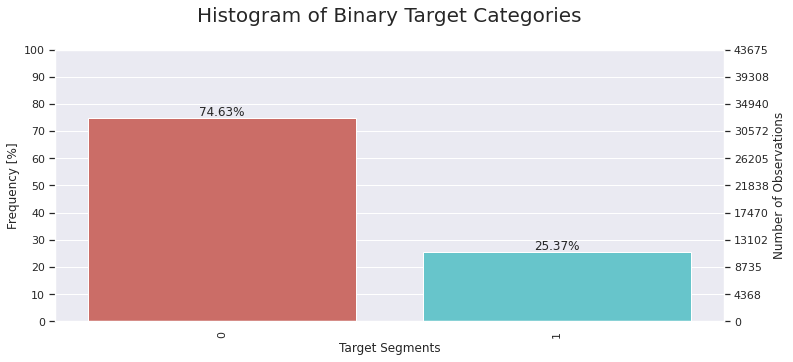

<Figure size 432x288 with 0 Axes>

In [0]:
histogram(X_train,Y_train)

After the separation of the train and test data we made, we see that the target distribution does not deteriorate.

#### **Histogram of Binary Target Categories for Test**


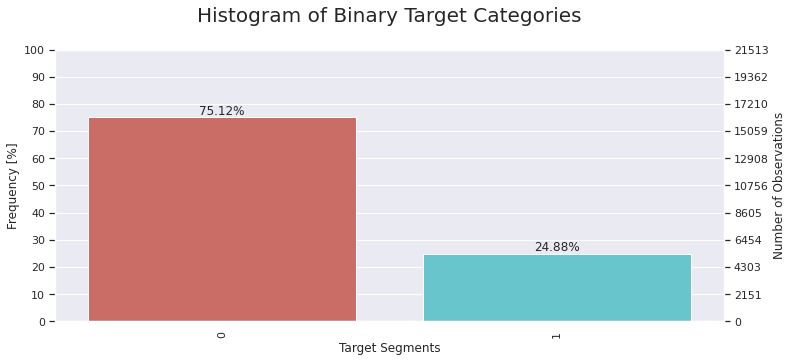

<Figure size 432x288 with 0 Axes>

In [0]:
histogram(X_test,Y_test)

## **Outlier Detection**

### Finding sparse columns

In [0]:
df_train = data.copy()
numerical_columns_remains = numerical_columns
        
sparse_columns = []
for col in numerical_columns_remains:
    if (df_train[col].quantile(0.01)==df_train[col].quantile(0.25)==df_train[col].mode()[0]):
        sparse_columns.append(col)

sparse_columns_2 = []
for col in numerical_columns_remains:
    if (df_train[col].quantile(0.01)==df_train[col].quantile(0.25)):
        sparse_columns_2.append(col)

len(numerical_columns_remains), len(sparse_columns), len(sparse_columns_2)

(10, 4, 4)

## **Visualization Before Cleaning Outlier**

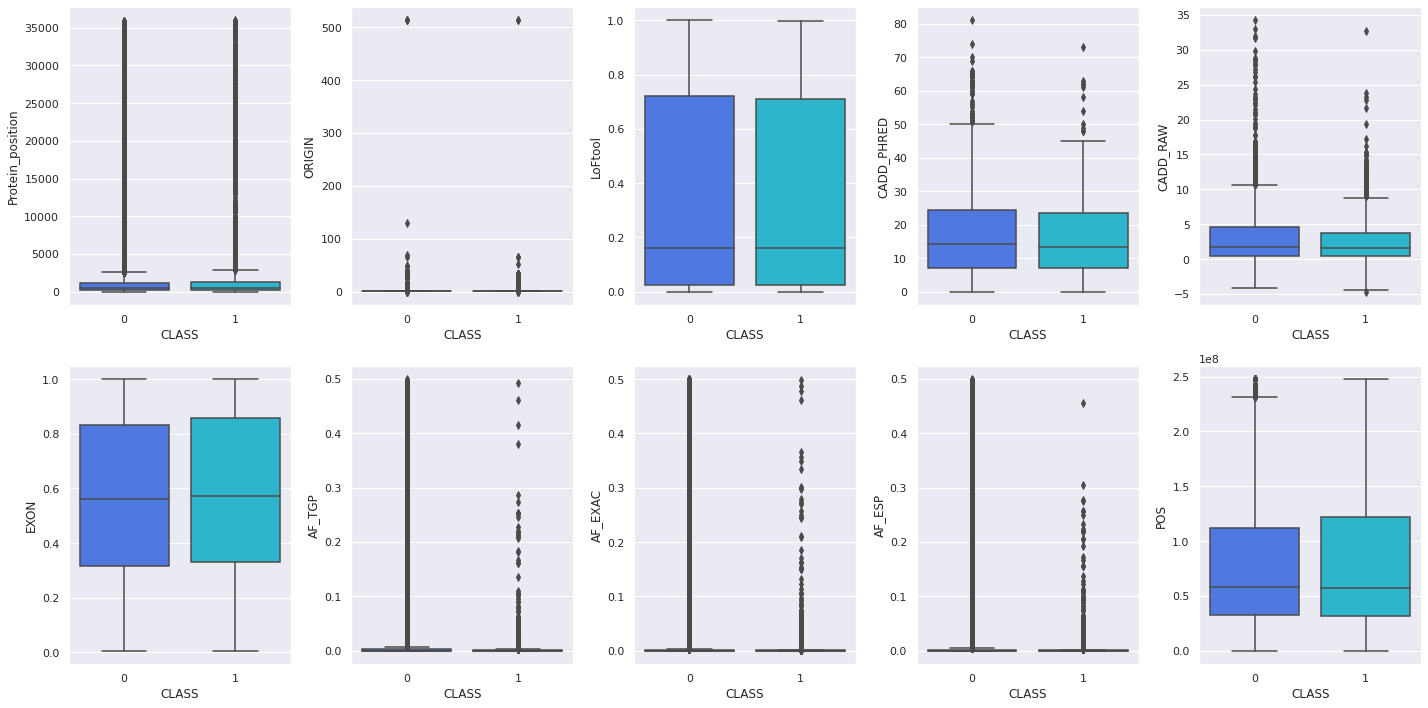

In [0]:
from pylab import rcParams

def box_plot(x,y,data):

  rcParams['figure.figsize'] = 20, 10
  fig, axs = plt.subplots(2,5)
  plt.tight_layout()
  fig.subplots_adjust(top=0.7)
  sns.set(style="ticks", palette="rainbow")

  j = 0
  k = 0
  for i in range(len(y)):
    sns.boxplot(x=x, y=y[i], data=data,ax=axs[j,k])
    if(k==4):
      k = 0
      j += 1
    else:
      k += 1

  plt.tight_layout()
  plt.show()

box_plot(Y_train,numerical_columns,X_train)

## **Cleaning Outliers for Train Dataset**



In [0]:
"""
Algorithm 'HER(Hard-Edges Method)' applies induction to the elements of a value line which are:

    - lower than the 1th quantile to that quantile and
    - upper than the 99th quantile to that quantile.
    
Main aim is to diminish negative effects of outlier values on analytical operations being performed.
"""

def HardEdgeReduction(df,numerical_columns,sparse_columns,upper_quantile=0.99,lower_quantile=0.01):
    
    import pandas as pd

    import psutil, os, gc, time
    print("HardEdgeReduction process has began:\n")
    proc = psutil.Process(os.getpid())
    gc.collect()
    mem_0 = proc.memory_info().rss
    start_time = time.time()
    
    # Do outlier cleaning in only one loop
    epsilon = 0.0001 # for zero divisions

    # Define boundaries that we will use for Reduction operation

    df_outlier_cleaned = df.copy()


    print("Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!\n")
    print("Total number of rows is: %s\n"%df_outlier_cleaned.shape[0])

    outlier_boundries_dict={}

    for col in numerical_columns:

        if col in sparse_columns:

            # First ignore the 'sparse' data points:
            nonsparse_data = pd.DataFrame(df_outlier_cleaned[df_outlier_cleaned[col] !=\
                                                             df_outlier_cleaned[col].mode()[0]][col]) 
            
            #we used only mode to catch sparse points, since we know/proved it is enough to do that.

            # Find Outlier Thresholds:
            # Note: All columns are right-skewed
            # For lower threshold (left-hand-side)
            if nonsparse_data[col].quantile(lower_quantile) < df_outlier_cleaned[col].mode()[0]: #Unexpected case
                lower_bound_sparse = nonsparse_data[col].quantile(lower_quantile)
            else:
                lower_bound_sparse = df_outlier_cleaned[col].mode()[0]
            
            # For upper threshold (right-hand-side)
            if nonsparse_data[col].quantile(upper_quantile) < df_outlier_cleaned[col].mode()[0]: #Unexpected case
                upper_bound_sparse = df_outlier_cleaned[col].mode()[0]
            else:
                upper_bound_sparse = nonsparse_data[col].quantile(upper_quantile)

            outlier_boundries_dict[col]=(lower_bound_sparse,upper_bound_sparse)

            # Inform user about the cardinality of Outlier existence:
            number_of_outliers = len(df_outlier_cleaned[(df_outlier_cleaned[col] < lower_bound_sparse) |\
                                                        (df_outlier_cleaned[col] > upper_bound_sparse)][col])
            print("Sparse: Outlier number in {} is equal to: ".format(col),round(number_of_outliers/(nonsparse_data.shape[0] -
                                                                                       nonsparse_data.isnull().sum()),2))

            # Replace Outliers with Edges --> 1% and 99%:
            if number_of_outliers > 0:

                # Replace 'left-hand-side' outliers with its 1% quantile value
                df_outlier_cleaned.loc[df_outlier_cleaned[col] < lower_bound_sparse,col] = lower_bound_sparse - epsilon # --> MAIN DF CHANGED

                # Replace 'right-hand-side' outliers with its 99% quantile value
                df_outlier_cleaned.loc[df_outlier_cleaned[col] > upper_bound_sparse,col] = upper_bound_sparse + epsilon # --> MAIN DF CHANGED

        else:
            # Find Edges:
            number_of_outliers = len(df_outlier_cleaned[(df_outlier_cleaned[col] < \
                                                         df_outlier_cleaned[col].quantile(lower_quantile))|\
                                                        (df_outlier_cleaned[col] > \
                                                         df_outlier_cleaned[col].quantile(upper_quantile))]\
                                     [col])
            print("Other: Outlier number in {} is equal to: ".format(col),round(number_of_outliers/(df[col].shape[0] -
                                                                                       df[col].isnull().sum()),2)) 

            # Replace 'Standard' outliers:
            if number_of_outliers > 0:
                # Replace all outliers with its %99 quartile
                lower_bound_sparse = df_outlier_cleaned[col].quantile(lower_quantile)
                df_outlier_cleaned.loc[df_outlier_cleaned[col] < \
                                       lower_bound_sparse,col] \
                = lower_bound_sparse  - epsilon

                upper_bound_sparse = df_outlier_cleaned[col].quantile(upper_quantile)
                df_outlier_cleaned.loc[df_outlier_cleaned[col] > \
                                       upper_bound_sparse,col] \
                = upper_bound_sparse  + epsilon

            outlier_boundries_dict[col]=(lower_bound_sparse,upper_bound_sparse)


    print('HardEdgeReduction process has been completed!')
    print("--- in %s minutes ---" % ((time.time() - start_time)/60))

    return df_outlier_cleaned, outlier_boundries_dict



In [0]:
X_train, outlier_boundries_dict = HardEdgeReduction(X_train,numerical_columns,sparse_columns)

HardEdgeReduction process has began:

Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!

Total number of rows is: 43675

Other: Outlier number in Protein_position is equal to:  0.02
Sparse: Outlier number in ORIGIN is equal to:  ORIGIN    0.01
dtype: float64
Other: Outlier number in LoFtool is equal to:  0.01
Other: Outlier number in CADD_PHRED is equal to:  0.02
Other: Outlier number in CADD_RAW is equal to:  0.02
Other: Outlier number in EXON is equal to:  0.01
Sparse: Outlier number in AF_TGP is equal to:  AF_TGP    0.01
dtype: float64
Sparse: Outlier number in AF_EXAC is equal to:  AF_EXAC    0.01
dtype: float64
Sparse: Outlier number in AF_ESP is equal to:  AF_ESP    0.01
dtype: float64
Other: Outlier number in POS is equal to:  0.02
HardEdgeReduction process has been completed!
--- in 0.003168936570485433 minutes ---


In [0]:
outlier_boundries_dict

{'AF_ESP': (0.0, 0.4314),
 'AF_EXAC': (0.0, 0.40970850000000014),
 'AF_TGP': (0.0, 0.4420940000000002),
 'CADD_PHRED': (0.002, 40.0),
 'CADD_RAW': (-1.77642407, 12.766849359999998),
 'EXON': (0.041666666666666664, 1.0),
 'LoFtool': (0.000276, 0.995),
 'ORIGIN': (0.0, 86.99999999999727),
 'POS': (1220365.1400000001, 237955382.2),
 'Protein_position': (9.0, 29000.939999999966)}

## **Cleaning Outliers for Test Dataset**

In [0]:
# Do outlier cleaning in only one loop
epsilon = 0.0001 # for zero divisions

# Define boundaries that we will use for Reduction operation
upper_quantile = 0.99
lower_quantile = 0.01

df_test_outlier_cleaned = X_test.copy()

print("Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!\n")
print("Total number of rows is: %s\n"%df_test_outlier_cleaned.shape[0])

for col in numerical_columns_remains:

      lower_bound = outlier_boundries_dict[col][0]
      upper_bound = outlier_boundries_dict[col][1]
        
      # Inform user about the cardinality of Outlier existence:
      number_of_outliers = len(df_test_outlier_cleaned[(df_test_outlier_cleaned[col] < lower_bound) |\
                                                        (df_test_outlier_cleaned[col] > upper_bound)][col])
      print("Outlier number in {} is equal to: ".format(col), round(number_of_outliers/
            (df_test_outlier_cleaned[col].shape[0] - df_test_outlier_cleaned[col].isnull().sum()),2))

      # Replace Outliers with Edges --> 1% and 99%:
      if number_of_outliers > 0:

          # Replace 'left-hand-side' outliers with its 1% quantile value
          df_test_outlier_cleaned.loc[df_test_outlier_cleaned[col] < lower_bound,col] = lower_bound  - epsilon # --> MAIN DF CHANGED
          
          # Replace 'right-hand-side' outliers with its 99% quantile value
          df_test_outlier_cleaned.loc[df_test_outlier_cleaned[col] > upper_bound,col] = upper_bound  + epsilon # --> MAIN DF CHANGED
        


Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!

Total number of rows is: 21513

Outlier number in Protein_position is equal to:  0.02
Outlier number in ORIGIN is equal to:  0.0
Outlier number in LoFtool is equal to:  0.01
Outlier number in CADD_PHRED is equal to:  0.02
Outlier number in CADD_RAW is equal to:  0.02
Outlier number in EXON is equal to:  0.01
Outlier number in AF_TGP is equal to:  0.0
Outlier number in AF_EXAC is equal to:  0.01
Outlier number in AF_ESP is equal to:  0.0
Outlier number in POS is equal to:  0.02


## **Visualization After Cleaning Outlier**

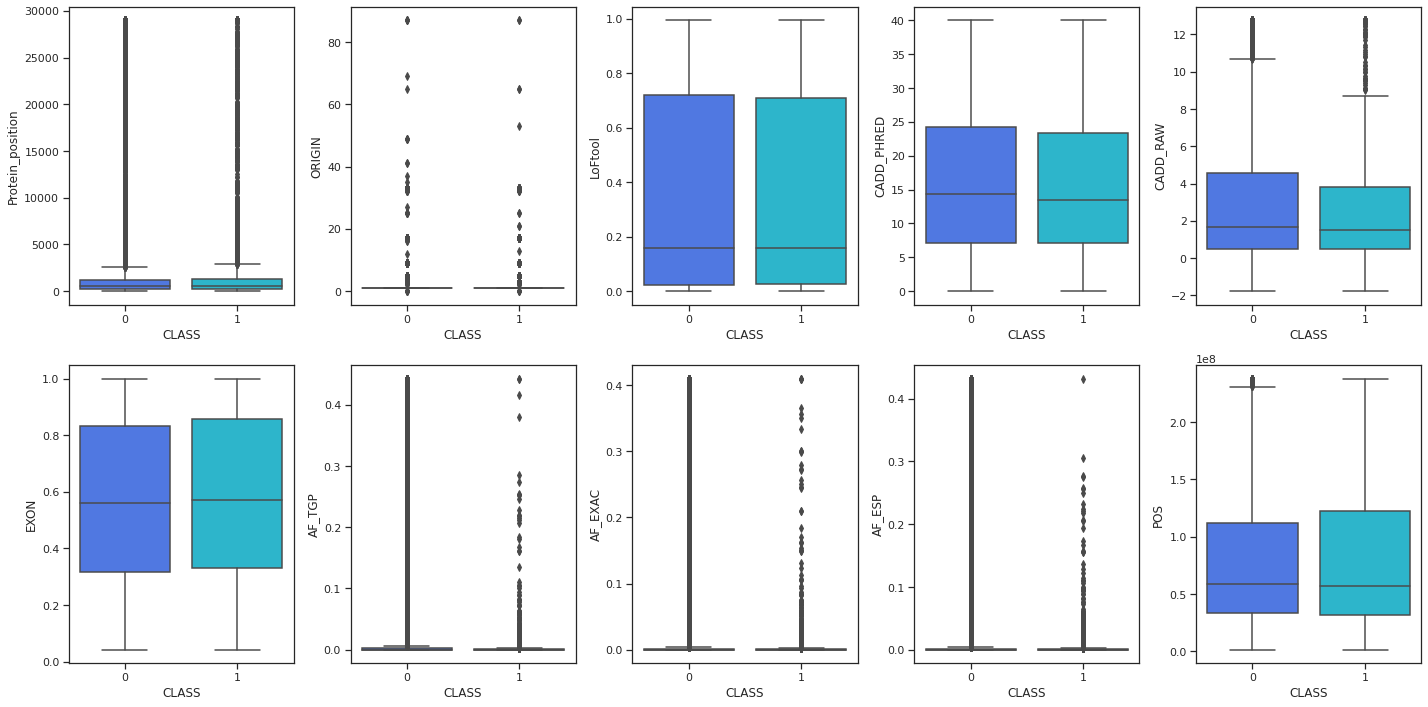

In [0]:
box_plot(Y_train,numerical_columns,X_train)

In [0]:
X_test = df_test_outlier_cleaned

# **Imputation for Missing Values**

<img src="https://cdn.discordapp.com/attachments/693138332166914077/698142092865830922/Missing_Value.png">

## **Specifying a range for missing values**

In [0]:
Zero_MR_variables_list = list(data_info[data_info['%_Missing_Value']==0].index)
Low_MR_variables_list = list(data_info[(data_info['%_Missing_Value']>0)&
                                       (data_info['%_Missing_Value']<=0.05)].index)
Moderate_MR_variables_list = list(data_info[(data_info['%_Missing_Value']>0.05)&\
                                                      (data_info['%_Missing_Value']<=0.25)].index)
High_MR_variables_list = list(data_info[(data_info['%_Missing_Value']>0.25)&\
                                                  (data_info['%_Missing_Value']<=0.50)].index)
Extreme_MR_variables_list = list(data_info[(data_info['%_Missing_Value']>0.50)&
                                           (data_info['%_Missing_Value']<=0.95)].index)
Drop_MR_variables_list = list(data_info[data_info['%_Missing_Value']>0.95].index)

len(Zero_MR_variables_list),len(Low_MR_variables_list),len(Moderate_MR_variables_list),len(High_MR_variables_list),\
len(Extreme_MR_variables_list),\
len(Zero_MR_variables_list)+len(Low_MR_variables_list)+len(Moderate_MR_variables_list)+len(High_MR_variables_list)+\
len(Extreme_MR_variables_list) == len(data_info)

(16, 8, 6, 0, 5, True)

# **Simple Imputer for Low Missing Values**

Filling in the null values ​​of columns with a missing value statistic less than 0.05

It does this according to the frequency of the data.

In [0]:
Low_MR_variables_list

['CADD_PHRED',
 'CADD_RAW',
 'EXON',
 'SYMBOL',
 'BIOTYPE',
 'STRAND',
 'Feature',
 'Feature_type']

In [0]:
def SimpleImputer(df,data_info,variable_list):
  for col in variable_list:
    
    if(col in numerical_columns):
      
      print("Total null values: {}".format(df[[str(col)]].isnull().sum()))

      average = float(df[col].mean())
      std = float(df[col].std())
      count_nan = int(df[col].isnull().sum())
      rand = np.random.normal(loc=average,scale=std,size =count_nan)
      slice_col = pd.Series(df[col].copy())
      slice_col[pd.isnull(slice_col)] = rand
      df[col] = slice_col

      print("Numerical variable {} have been imputed.".format(col))

    else:

      print("Total null values: {}".format(df[[str(col)]].isnull().sum()))
      df.loc[df.loc[:,col].isnull(),col] = np.random.choice(sorted(list(df.loc[:,col].dropna().unique())),
                                                            size=int(df.loc[df.loc[:,col].isnull(),col].shape[0]),
                                                            p=[pd.Series(df.groupby(col).size()/df.loc[:,col].dropna().shape[0]).iloc[i] for i in 
                                                               np.arange(0,len(df.loc[:,col].dropna().unique()))])
      
      print("Categorical variable {} have been imputed.".format(col))

In [0]:
SimpleImputer(X_train, data_info, Low_MR_variables_list)

Total null values: CADD_PHRED    731
dtype: int64
Numerical variable CADD_PHRED have been imputed.
Total null values: CADD_RAW    731
dtype: int64
Numerical variable CADD_RAW have been imputed.
Total null values: EXON    91
dtype: int64
Numerical variable EXON have been imputed.
Total null values: SYMBOL    12
dtype: int64
Categorical variable SYMBOL have been imputed.
Total null values: BIOTYPE    12
dtype: int64
Categorical variable BIOTYPE have been imputed.
Total null values: STRAND    11
dtype: int64
Categorical variable STRAND have been imputed.
Total null values: Feature    11
dtype: int64
Categorical variable Feature have been imputed.
Total null values: Feature_type    11
dtype: int64
Categorical variable Feature_type have been imputed.


In [0]:
SimpleImputer(X_test,data_info,Low_MR_variables_list)

Total null values: CADD_PHRED    361
dtype: int64
Numerical variable CADD_PHRED have been imputed.
Total null values: CADD_RAW    361
dtype: int64
Numerical variable CADD_RAW have been imputed.
Total null values: EXON    42
dtype: int64
Numerical variable EXON have been imputed.
Total null values: SYMBOL    4
dtype: int64
Categorical variable SYMBOL have been imputed.
Total null values: BIOTYPE    4
dtype: int64
Categorical variable BIOTYPE have been imputed.
Total null values: STRAND    3
dtype: int64
Categorical variable STRAND have been imputed.
Total null values: Feature    3
dtype: int64
Categorical variable Feature have been imputed.
Total null values: Feature_type    3
dtype: int64
Categorical variable Feature_type have been imputed.


In [0]:
MissingUniqueStatistics(X_train.loc[:,Low_MR_variables_list])

,Variable,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,Unique_Values,#_Uniques_Values
0,CADD_PHRED,43675,0,0.0,float64,"[18.17, 0.815, 25.3, 1.3430000000000002, 1.702...",8780
1,CADD_RAW,43675,0,0.0,float64,"[2.300417, -0.260285, 5.102551, -0.157085, -0....",42688
2,EXON,43675,0,0.0,float64,"[0.23809523809523808, 0.13924050632911392, 0.9...",2305
3,SYMBOL,43675,0,0.0,object,"[KIT, DMD, SCN5A, TGFBR2, BRCA2, CAPN3, FBN1, ...",2175
4,BIOTYPE,43675,0,0.0,object,"[protein_coding, misc_RNA]",2
5,STRAND,43675,0,0.0,float64,"[1.0, -1.0]",2
6,Feature,43675,0,0.0,object,"[XM_005265740.1, NM_004006.2, NM_001099404.1, ...",2207
7,Feature_type,43675,0,0.0,object,"[Transcript, MotifFeature]",2


In [0]:
MissingUniqueStatistics(X_test.loc[:,Low_MR_variables_list])

,Variable,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,Unique_Values,#_Uniques_Values
0,CADD_PHRED,21513,0,0.0,float64,"[14.7, 16.99, 23.0, 12.84, 36.0, 11.93, 0.003,...",5964
1,CADD_RAW,21513,0,0.0,float64,"[1.7518049999999998, 2.121372, 3.3863239999999...",21089
2,EXON,21513,0,0.0,float64,"[0.9047619047619048, 0.5, 0.8260869565217391, ...",1811
3,SYMBOL,21513,0,0.0,object,"[AARS, NBN, TRAPPC9, DLAT, MSH6, MYH7, AXIN2, ...",1886
4,BIOTYPE,21513,0,0.0,object,"[protein_coding, misc_RNA]",2
5,STRAND,21513,0,0.0,float64,"[-1.0, 1.0]",2
6,Feature,21513,0,0.0,object,"[XM_005255813.1, NM_002485.4, NM_031466.5, NM_...",1905
7,Feature_type,21513,0,0.0,object,"[Transcript, MotifFeature]",2


## **STRING CONVERSION**

Categorizes empty cells and converts them into numerical variables by using mean encoding.

## MEAN ENCODING

In [0]:
class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = False, random_state=2020)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = \
            X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'\
                  .format(col_mean_name,self.targetName,
                          np.corrcoef(X[self.targetName].values,
                                      encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X

In [0]:
def StringConverterTrain(df,target_name,variable_list):
    for col in variable_list:
      targetc = KFoldTargetEncoderTrain(col,target_name,n_fold=4)
      new_train = targetc.fit_transform(df)
    return new_train

In [0]:
nominal_variable = list(data_info[data_info["Variable_Type"]=="Nominal"].index)
nominal_lst = [item for item in Moderate_MR_variables_list+High_MR_variables_list+Extreme_MR_variables_list if item in nominal_variable]
nominal_lst

['Amino_acids', 'Codons', 'MC', 'BLOSUM62', 'CLNVI', 'BAM_EDIT']

In [0]:
df_trial = pd.concat([X_train,Y_train],axis=1).copy()
df_output_train = StringConverterTrain(df=df_trial,target_name="CLASS",variable_list=nominal_lst)

Correlation between the new feature, Amino_acids_Kfold_Target_Enc and, CLASS is 0.08334386544889374.
Correlation between the new feature, Codons_Kfold_Target_Enc and, CLASS is 0.059853289290142934.
Correlation between the new feature, MC_Kfold_Target_Enc and, CLASS is 0.11939519074813773.
Correlation between the new feature, BLOSUM62_Kfold_Target_Enc and, CLASS is 0.016757429148402114.
Correlation between the new feature, CLNVI_Kfold_Target_Enc and, CLASS is 0.035885209216811514.
Correlation between the new feature, BAM_EDIT_Kfold_Target_Enc and, CLASS is 0.01932517535354151.


In [0]:
for item in nominal_lst:
  print(df_output_train.loc[:,[item+"_Kfold_Target_Enc"]].isnull().sum())

Amino_acids_Kfold_Target_Enc    0
dtype: int64
Codons_Kfold_Target_Enc    0
dtype: int64
MC_Kfold_Target_Enc    0
dtype: int64
BLOSUM62_Kfold_Target_Enc    0
dtype: int64
CLNVI_Kfold_Target_Enc    0
dtype: int64
BAM_EDIT_Kfold_Target_Enc    0
dtype: int64


In [0]:
for item in nominal_lst:
  X_train[item] = df_output_train[item+"_Kfold_Target_Enc"]

# Mean Encoding for nominal variables(non missing value)

In [0]:
nominal_encoding_variable_lst =["Consequence","REF","ALT","CLNDISDB","CLNDN","Allele","Feature","SYMBOL"]

df_encoding = pd.concat([X_train,Y_train],axis=1).copy()
df_encoding_train = StringConverterTrain(df=df_encoding,target_name="CLASS",variable_list=nominal_encoding_variable_lst)

Correlation between the new feature, Consequence_Kfold_Target_Enc and, CLASS is 0.12954274050641354.
Correlation between the new feature, REF_Kfold_Target_Enc and, CLASS is 0.030981329939778965.
Correlation between the new feature, ALT_Kfold_Target_Enc and, CLASS is 0.019840739831770798.
Correlation between the new feature, CLNDISDB_Kfold_Target_Enc and, CLASS is 0.26095672345180904.
Correlation between the new feature, CLNDN_Kfold_Target_Enc and, CLASS is 0.2598131401648027.
Correlation between the new feature, Allele_Kfold_Target_Enc and, CLASS is 0.02706688729121655.
Correlation between the new feature, Feature_Kfold_Target_Enc and, CLASS is 0.1770296818192675.
Correlation between the new feature, SYMBOL_Kfold_Target_Enc and, CLASS is 0.17665378928781184.


In [0]:
for item in nominal_encoding_variable_lst:
  print(df_encoding_train.loc[:,[item+"_Kfold_Target_Enc"]].isnull().sum())

Consequence_Kfold_Target_Enc    0
dtype: int64
REF_Kfold_Target_Enc    0
dtype: int64
ALT_Kfold_Target_Enc    0
dtype: int64
CLNDISDB_Kfold_Target_Enc    0
dtype: int64
CLNDN_Kfold_Target_Enc    0
dtype: int64
Allele_Kfold_Target_Enc    0
dtype: int64
Feature_Kfold_Target_Enc    0
dtype: int64
SYMBOL_Kfold_Target_Enc    0
dtype: int64


In [0]:
for item in nominal_encoding_variable_lst:
  X_train[item] = df_encoding_train[item+"_Kfold_Target_Enc"]

In [0]:
MissingUniqueStatistics(X_train)

,Variable,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,Unique_Values,#_Uniques_Values
28,PolyPhen,16550,27125,0.6211,object,"[nan, benign, probably_damaging, possibly_dama...",5
27,SIFT,16590,27085,0.6201,object,"[nan, tolerated, deleterious, deleterious_low_...",5
22,Protein_position,37035,6640,0.1520,float64,"[275.0, 418.0, 1596.0, nan, 2699.0, 2233.0, 44...",4983
13,ORIGIN,39553,4122,0.0944,float64,"[1.0, nan, 33.0, 5.0, 69.0, 3.0, 32.0, 9.0, 25...",25
29,LoFtool,40857,2818,0.0645,float64,"[0.00227, 0.342, 0.000413, 0.0601, 0.0896, 0.0...",1151
0,CHROM,43675,0,0.0000,object,"[4, X, 3, 13, 15, 12, 5, 10, 22, 17, 7, 6, 8, ...",25
23,Amino_acids,43675,0,0.0000,float64,"[0.3053691275167785, 0.21008403361344538, 0.34...",487
19,Feature,43675,0,0.0000,float64,"[0.42857142857142855, 0.34615384615384615, 0.3...",604
20,BIOTYPE,43675,0,0.0000,object,"[protein_coding, misc_RNA]",2
21,EXON,43675,0,0.0000,float64,"[0.23809523809523808, 0.13924050632911392, 0.9...",2305


# **String Converter for Test Dataset**

In [0]:
df_output_test = X_test.copy()
mean_of_target = df_output_train['CLASS'].copy().mean()
target_mean_list = nominal_lst                                                 
for col in target_mean_list:
    df_output_test[col] = df_output_test[col].map(df_output_train.groupby(col)[col+'_Kfold_Target_Enc'].mean())
    df_output_test[col].fillna(mean_of_target, inplace = True)

In [0]:
for item in nominal_lst:
  print(df_output_test.loc[:,[item]].isnull().sum())

Amino_acids    0
dtype: int64
Codons    0
dtype: int64
MC    0
dtype: int64
BLOSUM62    0
dtype: int64
CLNVI    0
dtype: int64
BAM_EDIT    0
dtype: int64


In [0]:
X_test[nominal_lst] = df_output_test[nominal_lst]

In [0]:
X_test_encoder = X_test.copy()
mean_of_target = df_encoding_train['CLASS'].copy().mean()
target_mean_list = nominal_encoding_variable_lst                                                 
for col in target_mean_list:
    X_test_encoder[col+'_Kfold_Target_Enc'] = X_test_encoder[col].map(df_encoding_train.groupby(col)[col+'_Kfold_Target_Enc'].mean())
    X_test_encoder[col+'_Kfold_Target_Enc'].fillna(mean_of_target, inplace = True)

In [0]:
for item in nominal_encoding_variable_lst:
  X_test[item] = X_test_encoder[item+"_Kfold_Target_Enc"]
  
MissingUniqueStatistics(X_test[nominal_encoding_variable_lst])

,Variable,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,Unique_Values,#_Uniques_Values
0,Consequence,21513,0,0.0,float64,"[0.2586430766730627, 0.26426313417796, 0.06183...",32
1,REF,21513,0,0.0,float64,"[0.26448961839365676, 0.24028822573987135, 0.2...",51
2,ALT,21513,0,0.0,float64,"[0.2645337675591834, 0.23378530363441125, 0.24...",24
3,CLNDISDB,21513,0,0.0,float64,"[0.25371493989696625, 0.07203827022843728, 0.3...",826
4,CLNDN,21513,0,0.0,float64,"[0.25371493989696625, 0.07203827022843728, 0.3...",825
5,Allele,21513,0,0.0,float64,"[0.2654599365208286, 0.2369612252761201, 0.242...",23
6,Feature,21513,0,0.0,float64,"[0.26390714548609295, 0.16573738176298297, 0.2...",892
7,SYMBOL,21513,0,0.0,float64,"[0.26390714548609295, 0.16573738176298297, 0.2...",888


Our column "CLNHGVS" in the table has 65188 values ​​and all values ​​are unique. Therefore, we drop this column as it does not carry any information.

In [0]:
X_train.drop("CLNHGVS", axis = 1, inplace = True)
X_test.drop("CLNHGVS", axis = 1, inplace = True)

# Modal Based Imputation

In [0]:
def MBI(df,columns,train_or_test,lst_numerical):

  data_binary_encoded=df.copy()
  le=LabelEncoder()

  for col in columns:
    
    if(train_or_test == "test"):

      le.fit(X_train[col].copy().astype(str))
      data_binary_encoded[col]=le.transform(df[col].copy().astype(str))

    else:

      data_binary_encoded[col] = le.fit_transform(df[col].copy().astype(str))

  data_scaled=data_binary_encoded.copy()

  for col in numerical_columns:

    scaler = StandardScaler()

    if(train_or_test == "test"):

      scaler.fit(np.array(X_train.loc[:,col]).reshape(-1,1))
      data_scaled.loc[:,col] = scaler.transform(np.array(data_scaled.loc[:,col]).reshape(-1,1))

    else:
      data_scaled.loc[:,col] = scaler.fit_transform(np.array(data_scaled.loc[:,col]).reshape(-1,1))

  for col in lst_numerical:

    target_dropped_fullcases = data_scaled.drop(col,axis=1).loc[:,list(set(Zero_MR_variables_list+Low_MR_variables_list)-
                                                                                  set(["CLASS","KEY","CLNHGVS"]))].copy()
    
    target = data_scaled.loc[:,col]
    null_mask = target.isna()
    print(col)

    if(col in numerical_columns):
      
      mlp = MLPRegressor(hidden_layer_sizes=(100,10,),
                        activation='tanh',
                        solver='adam',
                        learning_rate='adaptive',
                        max_iter=1000,
                        learning_rate_init=0.01,
                        alpha=0.01,
                        early_stopping = False)
    else:
      mlp = MLPClassifier(hidden_layer_sizes=(100,10,),
                        activation='tanh',
                        solver='adam',
                        learning_rate='adaptive',
                        max_iter=1000,
                        learning_rate_init=0.01,
                        alpha=0.01,
                        early_stopping = False)
    
    mlp.fit(target_dropped_fullcases[~null_mask],target[~null_mask])
    data_scaled.loc[null_mask,col] = mlp.predict(target_dropped_fullcases[null_mask])

  print(data_scaled.loc[:,lst_numerical].isnull().sum());
  return data_scaled

In [0]:
lst_numerical = [item for item in Moderate_MR_variables_list if item in numerical_columns]
lst_numerical.append("SIFT")
lst_numerical.append("PolyPhen")
lst_numerical

['Protein_position', 'ORIGIN', 'LoFtool', 'SIFT', 'PolyPhen']

In [0]:
encoding_col_list =["CHROM","CLNVC","Feature_type","BIOTYPE","IMPACT"]


# **Scaling**

In [0]:
X_train_scaled = MBI(X_train,encoding_col_list,"train",lst_numerical)

Protein_position
ORIGIN
LoFtool
SIFT
PolyPhen
Protein_position    0
ORIGIN              0
LoFtool             0
SIFT                0
PolyPhen            0
dtype: int64


In [0]:
X_train_scaled

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNVC,CLNVI,MC,ORIGIN,Allele,Consequence,IMPACT,SYMBOL,Feature_type,Feature,BIOTYPE,EXON,Protein_position,Amino_acids,Codons,STRAND,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
16188,16,-0.369982,0.260734,0.261150,-0.245430,-0.239160,-0.254282,0.253715,0.253715,6,0.253715,0.259545,-0.089496,0.261634,0.263488,2,0.428571,1,0.428571,1,-1.101438,-0.319217,0.305369,0.305369,1.0,0.253715,tolerated,benign,-0.955233,0.238173,-0.083773,0.262056
63762,23,-0.753928,0.236395,0.268139,-0.248961,-0.243017,-0.257712,0.000000,0.000000,6,0.253715,0.259545,-0.089496,0.270146,0.263488,2,0.346154,1,0.346154,1,-1.432212,-0.284707,0.210084,0.066667,-1.0,0.252123,tolerated,benign,-0.015810,-1.389719,-0.985201,0.254673
14115,15,-0.654479,0.244387,0.261150,-0.252492,-0.245998,-0.257712,0.253715,0.253715,6,0.416667,0.253715,0.102090,0.261634,0.263488,2,0.352564,1,0.352564,1,1.328438,-0.000420,0.347826,0.333333,-1.0,0.253715,deleterious,benign,-0.960368,0.906964,0.902645,0.253715
13538,15,-0.787045,0.244387,0.245113,5.423757,6.285275,6.824692,0.166667,0.166667,6,0.253715,0.287110,-0.089496,0.246671,0.357647,1,0.380952,1,0.380952,1,-0.464094,-0.194980,0.253715,0.253715,1.0,0.253715,tolerated,benign,-0.795321,-1.340193,-0.948872,0.253715
41780,4,-0.749317,0.236395,0.230822,-0.252492,-0.247226,-0.257712,0.142857,0.142857,6,0.253715,0.258729,-0.089496,0.235652,0.260056,1,0.286788,1,0.286788,1,0.332587,0.265767,0.248744,0.213592,1.0,0.252123,tolerated,benign,-0.713748,-1.306519,-0.930096,0.253715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62570,14,-0.813283,0.239255,0.232793,-0.250727,-0.246699,-0.257712,0.093878,0.093878,6,0.253715,0.290130,-0.089496,0.235305,0.355993,1,0.132841,1,0.136029,1,-0.782766,-0.237952,0.253715,0.253715,-1.0,0.249039,tolerated,benign,0.022903,-1.324059,-0.939484,0.253715
38158,3,-0.583034,0.265299,0.266003,-0.252492,-0.247050,-0.257712,0.400000,0.400000,6,0.253715,0.261715,-0.089496,0.266966,0.264221,2,0.352941,1,0.352941,1,1.029682,-0.276019,0.299559,0.330882,-1.0,0.253715,tolerated,benign,-0.748036,-0.135150,-0.308650,0.266426
860,0,-0.863211,0.267671,0.267125,-0.213650,-0.194973,-0.189101,1.000000,1.000000,6,0.253715,0.261715,-0.089496,0.269015,0.264221,2,0.571429,1,0.571429,1,1.447940,-0.253093,0.307065,0.307065,1.0,0.249039,tolerated,benign,-0.624155,-0.629942,-0.642395,0.266426
15795,16,-1.206796,0.267671,0.267125,-0.185401,-0.230743,-0.195962,0.600000,0.600000,6,0.253715,0.260599,-0.089496,0.269015,0.261171,1,0.454545,1,0.454545,1,-0.377183,-0.287120,0.251946,0.286604,-1.0,0.249039,tolerated,benign,1.657138,-0.561938,-0.601825,0.253715


In [0]:
X_test_scaled = MBI(X_test,encoding_col_list,"test",lst_numerical)

Protein_position
ORIGIN
LoFtool
SIFT
PolyPhen
Protein_position    0
ORIGIN              0
LoFtool             0
SIFT                0
PolyPhen            0
dtype: int64


In [0]:
def Label_Encoder(df,columns,train_or_test):
  le = LabelEncoder()
  for col in columns:
    if(train_or_test == "test"):

      le.fit(X_train_scaled[col].copy().astype(str))
      df[col] = le.transform(df[col].copy().astype(str))

    else:
      df[col] = le.fit_transform(df[col].copy().astype(str))

  return df

In [0]:
X_test_scaled = Label_Encoder(X_test_scaled,["SIFT","PolyPhen"],"test")

In [0]:
X_train_scaled = Label_Encoder(X_train_scaled,["SIFT","PolyPhen"],"train")

# Feature Importance

In [0]:
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train_scaled, Y_train)

features = X_train_scaled.columns
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

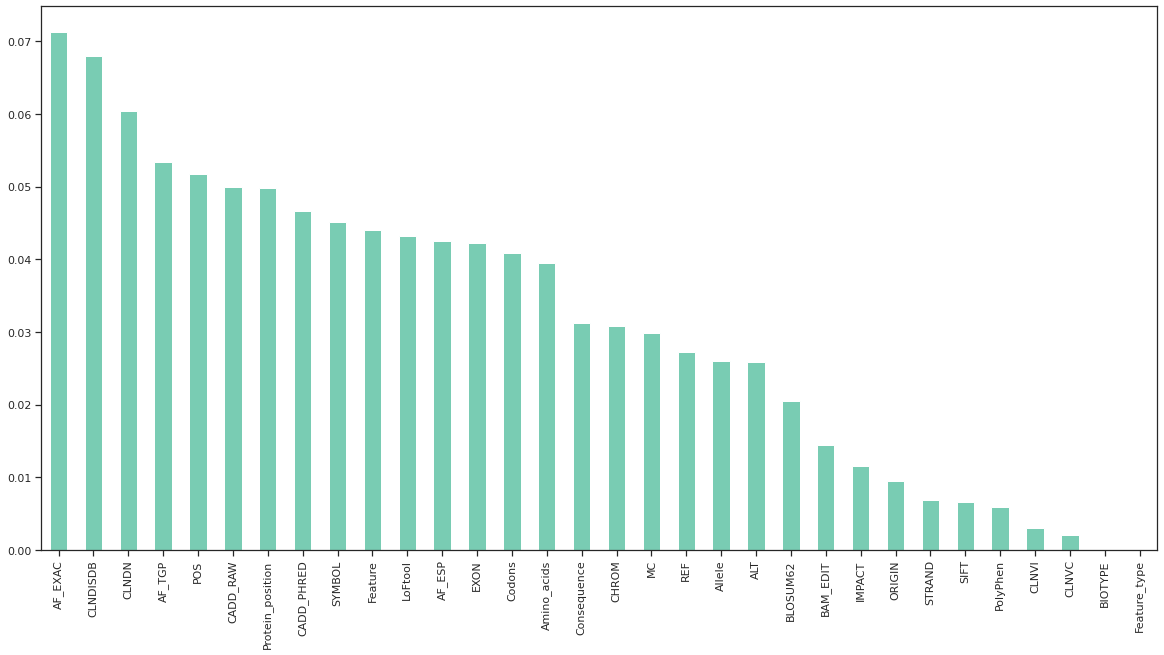

In [0]:
plt.figure(figsize=(20,10))
feat_importances = pd.Series(importances, index=features)
feat_importances.nlargest(len(indices)).plot(kind='bar',color = '#79CCB3');

# MODELLING

In [0]:
# Creating an empty Dataframe with Scores
df_accur_roc_score = pd.DataFrame(columns=['Roc_Auc_Score'])

## **Logistic Regression**

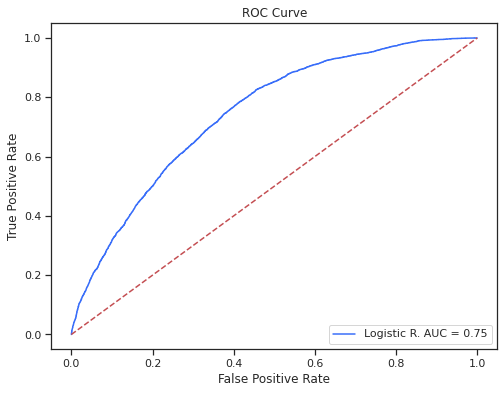

In [0]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)
clf.fit(X_train_scaled, Y_train)

y_preds = clf.predict_proba(X_test_scaled)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['Logistic_regression'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Logistic R. AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## **XGBoost Classifier**

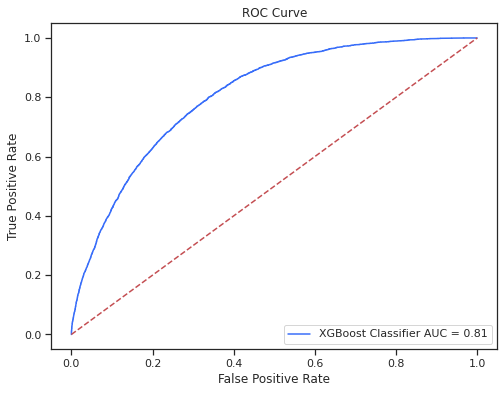

In [0]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=150,random_state=0,learning_rate=0.25,eta=0.4,booster="gbtree",base_score=0.8,colsample_bylevel=0.9009229642844634,gamma=0.49967765132613584,
                        max_depth=6,min_child_weight=7,reg_lambda=0.27611902459972926,subsample=0.9300916052594785)

xgb_model.fit(X_train_scaled, Y_train)

y_preds = xgb_model.predict_proba(X_test_scaled)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['XGBoost_Classifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='XGBoost Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()


## **KNeighbors Classifier**

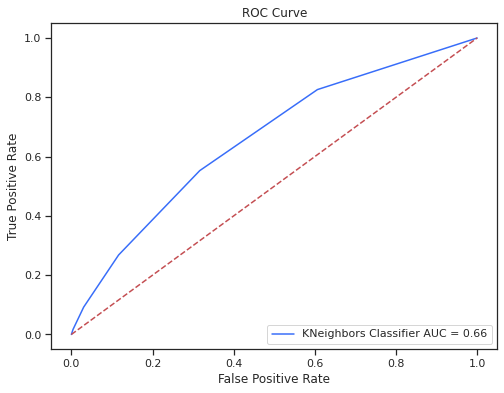

In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_scaled,Y_train)
y_preds = knn.predict_proba(X_test_scaled)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['KNeighborsClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='KNeighbors Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## **Decision Tree Classifier**

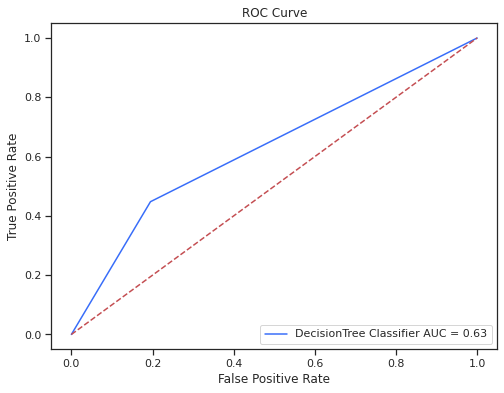

In [0]:
from sklearn.tree import DecisionTreeClassifier

reg_dtr = DecisionTreeClassifier(random_state=0)
reg_dtr.fit(X_train_scaled,Y_train)

y_preds = reg_dtr.predict_proba(X_test_scaled)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['DecisionTreeClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='DecisionTree Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

##  **LightGBM Classifier**

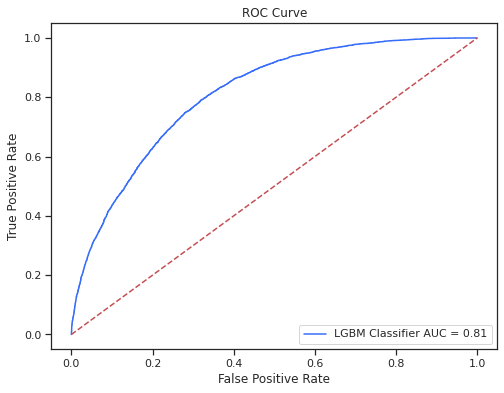

In [0]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
        max_depth=6,
        n_estimators=100,random_state=0,learning_rate=0.1,eta=0.4,base_score=0.8,colsample_bylevel=0.9009229642844634,gamma=0.49967765132613584,
                        min_child_weight=9,reg_lambda=0.27611902459972926,subsample=0.9300916052594785,min_samples_split=2,min_samples_leaf=0.1)

lgbm.fit(X_train_scaled, Y_train)

y_preds = lgbm.predict_proba(X_test_scaled)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['LGBMClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='LGBM Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Gradient Boosting Classifier

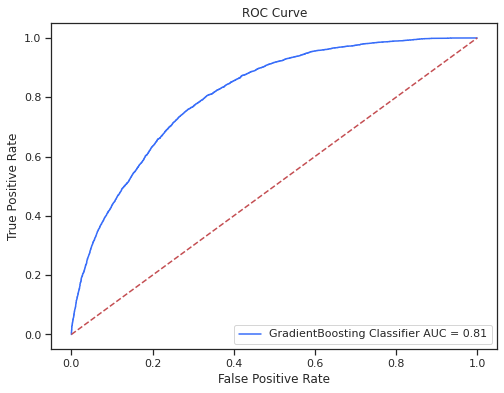

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                                   max_depth=7, random_state=0).fit(X_train_scaled, Y_train)

y_preds = gradient_boosting_clf.predict_proba(X_test_scaled)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['GradientBoostingClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='GradientBoosting Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## **Hist Gradient Boosting Classifier**

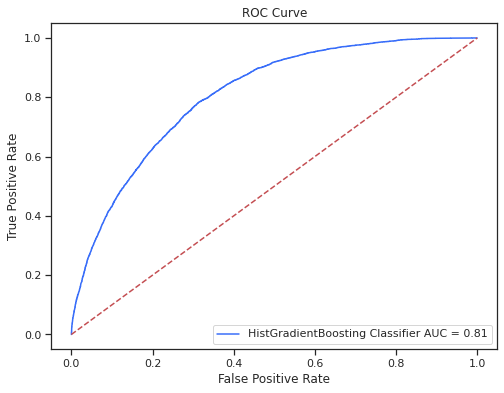

In [0]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


hist_gradient_boosting_clf = HistGradientBoostingClassifier(learning_rate=0.25,
                                                   max_depth=4, random_state=0).fit(X_train_scaled, Y_train)

y_preds = hist_gradient_boosting_clf.predict_proba(X_test_scaled)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['HistGradientBoostingClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.plot(fpr, tpr, label='HistGradientBoosting Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC Curve')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()


In [0]:
df_accur_roc_score


,Roc_Auc_Score
Logistic_regression,0.745550
XGBoost_Classifier,0.806908
KNeighborsClassifier,0.658297
DecisionTreeClassifier,0.626430
LGBMClassifier,0.810482
GradientBoostingClassifier,0.810347
HistGradientBoostingClassifier,0.808507


# **Visualization Model Outputs**

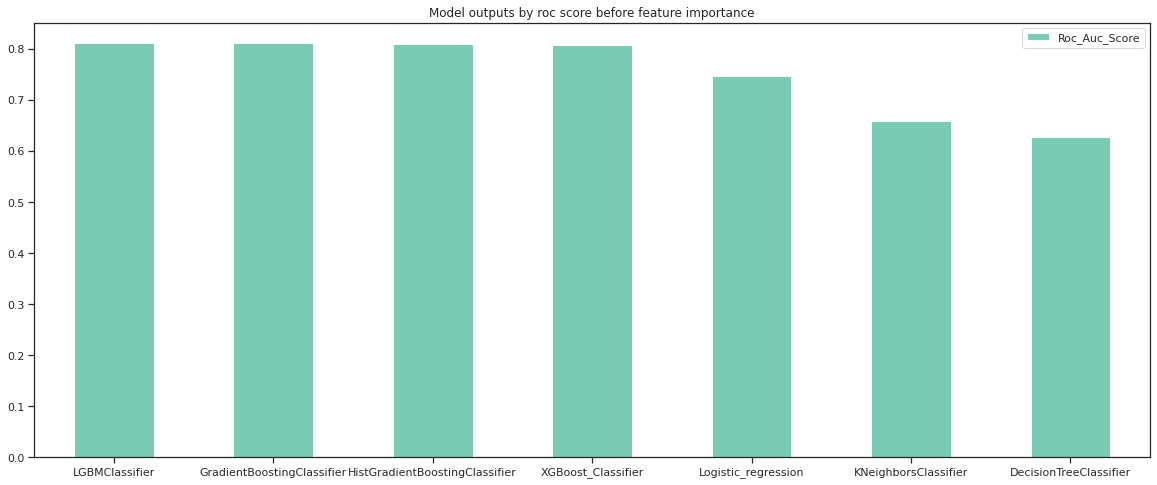

In [0]:
df_accur_roc_score.sort_values(by=['Roc_Auc_Score'],ascending=False).plot(kind='bar', y='Roc_Auc_Score',figsize=(20,8),color='#79ccb3', rot=0,title="Model outputs by roc score before feature importance");

# **Changing Dataset using Feature Importance** 

In [0]:
lst_importance_drop = []

for item in range(0,feat_importances.shape[0]):
  
  if(feat_importances[item] < 0.004):
    lst_importance_drop.append(features[item])

X_train_importance = X_train_scaled.drop(lst_importance_drop,axis=1)
X_test_importance = X_test_scaled.drop(lst_importance_drop,axis=1)

lst_importance_drop

['CLNVC', 'CLNVI', 'Feature_type', 'BIOTYPE']

In [0]:
# Creating an empty Dataframe with Scores
df_accur_roc_score_importance = pd.DataFrame(columns=['Roc_Auc_Score'])

### **Logistic Regression**

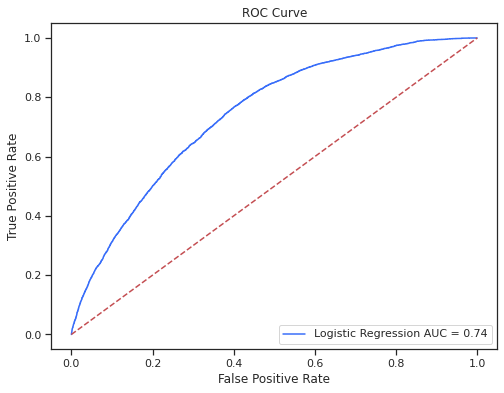

In [0]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=0)
clf = logreg.fit(X_train_importance, Y_train)

y_preds = clf.predict_proba(X_test_importance)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score_importance.loc['Logistic_regression'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Logistic Regression AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

### **XGBoost Classifier**

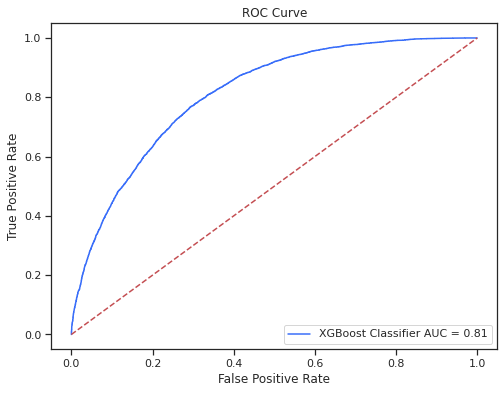

In [0]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=150,random_state=0,learning_rate=0.1,eta=0.4,booster="gbtree",base_score=0.8,colsample_bylevel=0.9009229642844634,gamma=0.49967765132613584,
                        max_depth=6,min_child_weight=7,reg_lambda=0.27611902459972926,subsample=0.9300916052594785)

xgb_model.fit(X_train_importance, Y_train)
y_preds = xgb_model.predict_proba(X_test_importance)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score_importance.loc['XGBoost_Classifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='XGBoost Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

### **KNeighbors Classifier**

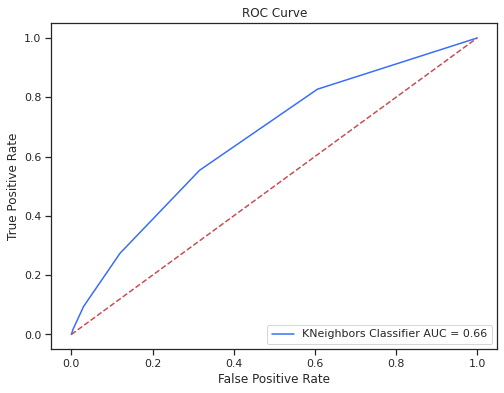

In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_importance,Y_train)
y_preds = knn.predict_proba(X_test_importance)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score_importance.loc['KNeighborsClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='KNeighbors Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

### **Decision Tree Classifier**

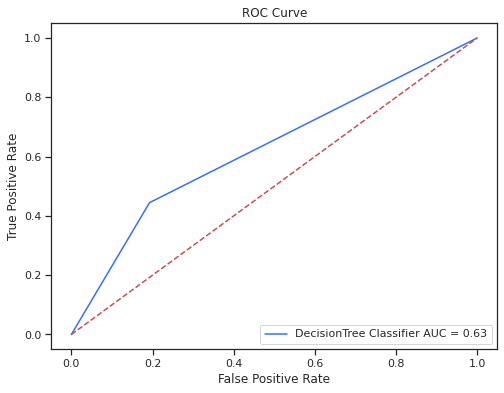

In [0]:
from sklearn.tree import DecisionTreeClassifier

reg_dtr = DecisionTreeClassifier(random_state=0)
reg_dtr.fit(X_train_importance,Y_train)

y_preds = reg_dtr.predict_proba(X_test_importance)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score_importance.loc['DecisionTreeClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='DecisionTree Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

### **LightGBM Classifier**

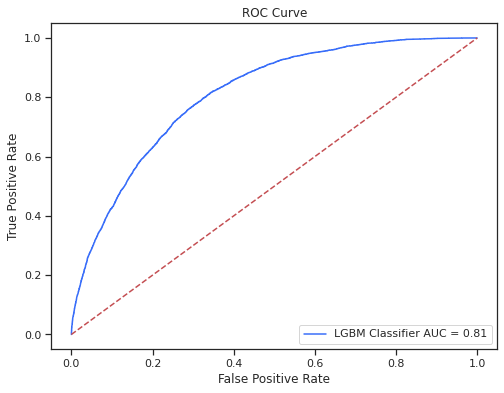

In [0]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
        max_depth=6,
        n_estimators=100,random_state=0,learning_rate=0.25,eta=0.4,base_score=0.8,colsample_bylevel=0.9009229642844634,gamma=0.49967765132613584,
                        min_child_weight=7,reg_lambda=0.27611902459972926,subsample=0.9300916052594785,min_sample_split=2)

lgbm.fit(X_train_importance, Y_train)

y_preds = lgbm.predict_proba(X_test_importance)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score_importance.loc['LGBMClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='LGBM Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

### **Gradient Boosting Classifier**

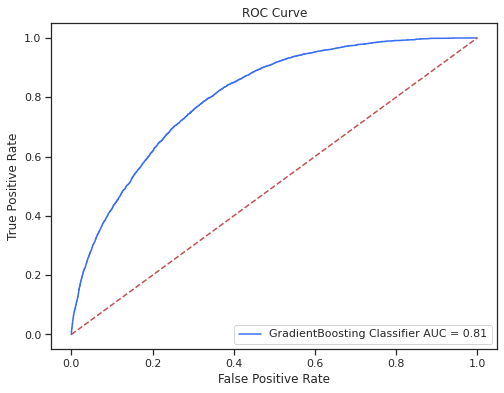

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                                   max_depth=5, random_state=0).fit(X_train_importance, Y_train)


y_preds = gradient_boosting_clf.predict_proba(X_test_importance)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score_importance.loc['GradientBoostingClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='GradientBoosting Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

### **Hist Gradient Boosting Classifier**

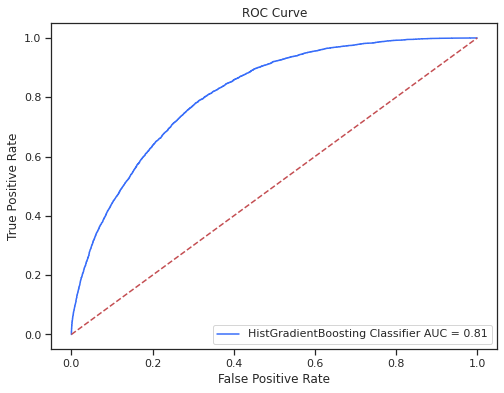

In [0]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gradient_boosting_clf = HistGradientBoostingClassifier(learning_rate=0.1,
                                                   max_depth=7, random_state=0).fit(X_train_importance, Y_train)

y_preds = hist_gradient_boosting_clf.predict_proba(X_test_importance)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score_importance.loc['HistGradientBoostingClassifier'] = [auc_score]
plt.subplots(figsize=(8, 6))
plt.plot(fpr, tpr, label='HistGradientBoosting Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.title('ROC Curve')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

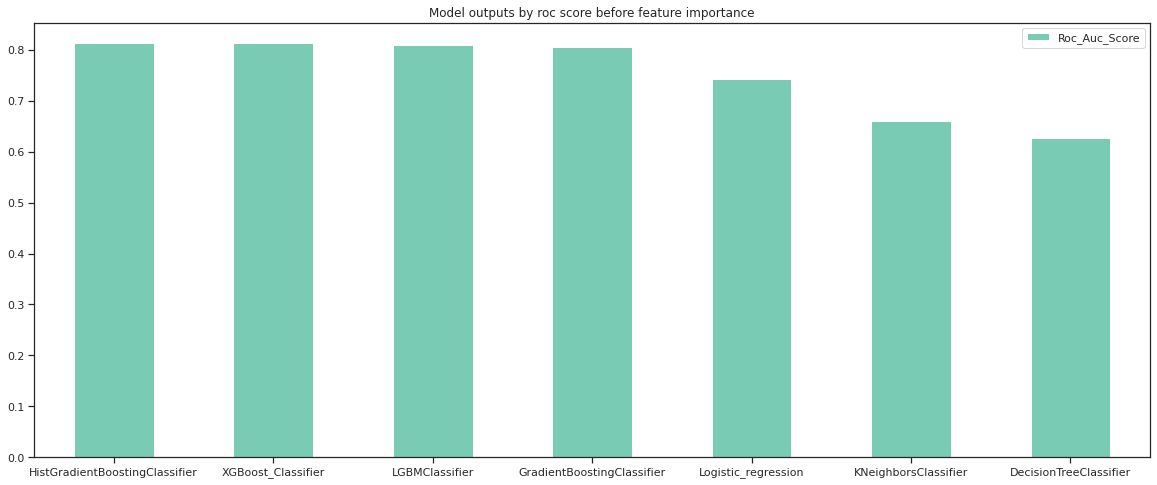

In [0]:
df_accur_roc_score_importance.sort_values(by=['Roc_Auc_Score'],ascending=False).plot(kind='bar', y='Roc_Auc_Score',figsize=(20,8),color='#79ccb3', rot=0,title="Model outputs by roc score before feature importance");

### **Visualization for After Feature Importance and Before Feature Importance**

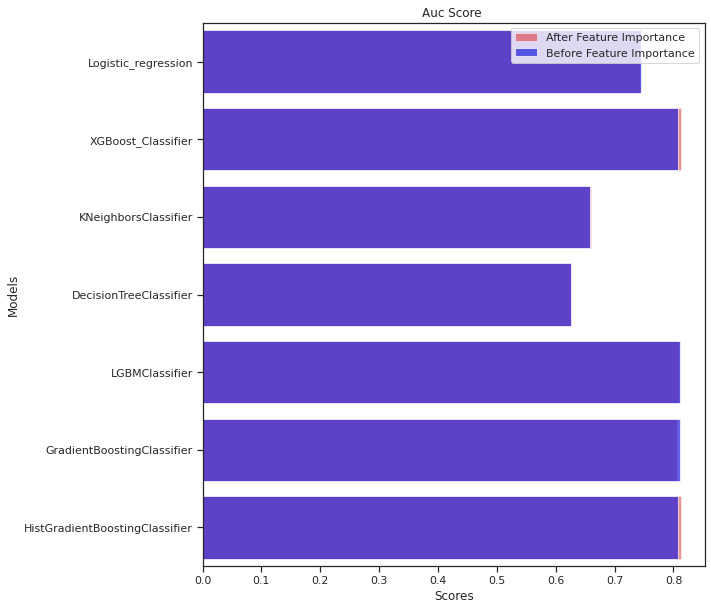

In [0]:
f,ax = plt.subplots(figsize = (9,10))
sns.barplot(x=df_accur_roc_score_importance.Roc_Auc_Score,y=df_accur_roc_score_importance.index,color='red',alpha = 0.5,label='After Feature Importance' )
sns.barplot(x=df_accur_roc_score.Roc_Auc_Score,y=df_accur_roc_score.index,color='blue',alpha = 0.7,label='Before Feature Importance')

ax.legend(frameon = True)
ax.set(xlabel='Scores', ylabel='Models',title = "Auc Score ")
plt.show()

In [0]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Before Feature Importance', y=df_accur_roc_score.Roc_Auc_Score, x=df_accur_roc_score.index,text=round(df_accur_roc_score.Roc_Auc_Score,3),textposition='auto'),
    go.Bar(name='After Feature Importance', y=df_accur_roc_score_importance.Roc_Auc_Score, x=df_accur_roc_score_importance.index,text=round(df_accur_roc_score_importance.Roc_Auc_Score,3),textposition='auto',)
    
])
fig.update_layout(barmode='group')
fig.show()

![alt text](https://cdn.discordapp.com/attachments/693138332166914077/698263762855002164/Ekran_Resmi_2020-04-10_23.08.13.png)